In [1]:
import yt.units as u
import matplotlib.pyplot as plt
import numpy
import sys
from scipy.integrate import odeint
from scipy.interpolate import interp1d

/home/kwoksun2/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_jeans_ml( rho, T, mu = 1.6):
    
    
    lambda_J  = numpy.sqrt( 15.0 * T * u.boltzmann_constant * u.K)
    lambda_J  = lambda_J / numpy.sqrt(4.0*numpy.pi*u.G * mu* u.mass_hydrogen * rho)
    
    M_J =  4.0/3.0 * numpy.pi* rho * lambda_J**3
    
#     print(lambda_J.in_units('pc'))
    return M_J.in_units('Msun'), lambda_J.in_units('pc')

def get_timescale( rho, T, f = 2.0e-4, mu = 1.6 ):
    
    U = 3.0/2.0 * rho / mu / u.mass_hydrogen * u.boltzmann_constant * u.K * T
    
    # tegmark 1997
    T3 = T / 1000.0
    n  = (rho / mu / u.mass_hydrogen ).in_cgs().v
    tau_cool = 48200 * u.yr * ( 1.0 + (10*(T3)**3.5) / ( 60.0 + T3**4 ) )**-1.0 * numpy.exp(512 / T ) * (f * n)**-1.0
    
    tau_ff = (1.0 / numpy.sqrt( u.G * rho ) ).in_units('yr')
    
    return tau_cool, tau_ff

def get_rho_profile( r, rho, Rs ):
#     print(Rs, r)
    return rho/ ( (r / Rs) * (1.0  + r/Rs)**2.0 )

def get_total_mass( Rs, Rmax, rho ):
    total_M = 4.0 * numpy.pi* rho * Rs**3 *( numpy.log( (Rs + Rmax) / Rs ) - Rmax / (Rs + Rmax) )
    return total_M
                            
def rhs(y, r_,rho, Rs):
    
    # y[0] : rho_g(R)
    # y[1] : m(R)
    
    # r_ in units of pc
    # m_r in units of Msun
    # rho_g in units of cm**-3
    
    rho_g = y[0] * u.mass_hydrogen * u.cm**-3
    m_r   = y[1] * u.Msun
    r_     = r_ * u.pc
    rho_d = get_rho_profile(r_, rho, Rs )
    
    ydot0 = -u.G * m_r / r_ / r_ * (rho_g )
    ydot0 /= u.boltzmann_constant * T * u.K / 1.6 / u.mass_hydrogen     
    ydot0 = ydot0.in_units('g / cm**3 / pc') / u.mass_hydrogen
    
    ydot1  = 4.0 * numpy.pi * (rho_d + rho_g ) * r_ * r_     
    ydot1 = ydot1.in_units('Msun / pc')
    
    ydot = numpy.zeros((2))
    ydot[0] = ydot0.value
    ydot[1] = ydot1.value

    return ydot

import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [3]:
Rmax = 100 * u.pc
Rs   = 40.0 * u.pc
rho  =  2.0e-22 * u.g * u.cm**-3
T = 2000.0

r_min = min( numpy.abs(numpy.linspace( -0.5,0.5,96 )) )* 100.0
r_max = 2.0 * max( numpy.abs(numpy.linspace( -0.5,0.5,96 )) )* 100.0
r = numpy.linspace( r_min , r_max, 5000)
# r = numpy.linspace(1e-2, 1e2, 1000)

y = numpy.zeros(2)

rho_d0 = get_rho_profile(min(r * u.pc ), rho, Rs)
rho_g0 = rho_d0 * 0.05

y[0] = (rho_g0 / u.mass_hydrogen).value
y[1] = ((  rho_g0 + rho_d0 ) *( (min(r * u.pc )**3.0) )  * 4.0/3.0*numpy.pi).in_units('Msun').value


sol = odeint(rhs, y, r ,args = (rho, Rs))

In [3]:
def get_profile( Rs, rho, T = 1000.0 , N = 64, Rmax = 100 * u.pc  ):
    
    
    r_min = min( numpy.abs(numpy.linspace( -1,1, N )) )* Rmax
    r_max = 2.0 * max( numpy.abs(numpy.linspace( -1,1,N )) )* Rmax
    r = numpy.linspace( r_min , r_max, 10000)
    # r = numpy.linspace(1e-2, 1e2, 1000)

    y = numpy.zeros(2)

    rho_d0 = get_rho_profile(min(r  ), rho, Rs)
    rho_g0 = rho_d0 * 0.05

    y[0] = (rho_g0 / u.mass_hydrogen).value
    y[1] = ((  rho_g0 + rho_d0 ) *( (min(r  )**3.0) )  * 4.0/3.0*numpy.pi).in_units('Msun').value


    sol = odeint(rhs, y, r ,args = (rho, Rs))
    
    return r, sol[:,0], sol[:,1]

def error_function(Rs, rho, T = 1000.0*u.K):
    Rs *= u.pc
    rho*= u.g * u.cm**-3
    r, rho_g, M_enc = get_profile( Rs, rho, T = 1000.0 *u.K, N = 64, Rmax = 100 * u.pc  )
    
    idx = find_nearest(r.v, 100)
    
    m_g = []
    for ir in range(len(r)):
        m_g.append(numpy.trapz( (rho_prof * 4.0*numpy.pi * (r)**2.0)[:ir], (r)[:ir] ).in_units('Msun'))
    
    
    mj, _ = get_jeans_ml( rho_g* u.mass_hydrogen * u.cm**-3, T.v, mu = 1.6)
    
    error = numpy.sqrt(numpy.abs( m_g[idx] - mj[idx] )**2.0)
    plt.plot(r, m_g)
    plt.plot(r, mj)
    plt.show()
    return error

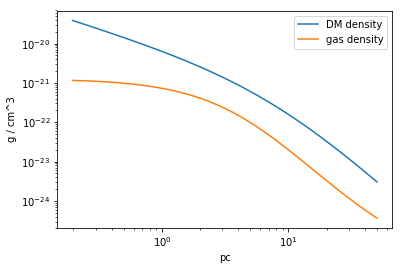

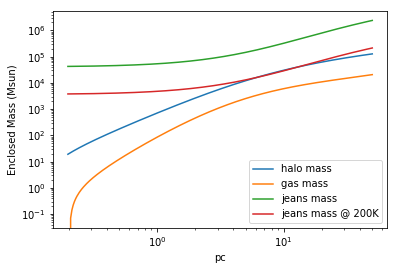

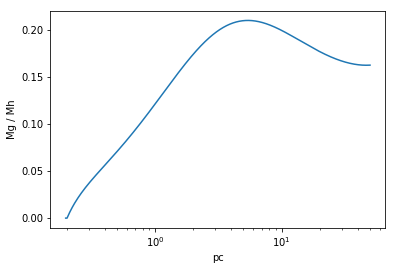

In [19]:
Rmax = 100 * u.pc
Rs   = 8.0 * u.pc
rho  =  1.0e-21 * u.g * u.cm**-3
T = 1000.0

r, rho_g, M_enc = get_profile( Rs, rho, T = T, N = 128, Rmax = 25 * u.pc  )

rho_d = get_rho_profile(r, rho, Rs)
plt.loglog(r, rho_d , label='DM density')
plt.loglog(r, rho_g * 1.0e-24, label='gas density')
plt.legend()
plt.xlabel('pc')
plt.ylabel('g / cm^3')
plt.show()

rho_prof = rho_g*u.mass_hydrogen* ( u.cm**-3)
m_g = []
for ir in range(len(r)):
    m_g.append(numpy.trapz( (rho_prof * 4.0*numpy.pi * r**2.0)[:ir], r[:ir] ).in_units('Msun'))

plt.loglog(r, M_enc, label='halo mass')
plt.loglog(r, m_g, label='gas mass')
mj, _ = get_jeans_ml( rho_prof, T, mu = 1.6)
mj200, _ = get_jeans_ml( rho_prof, 200.0, mu = 1.6)
plt.loglog(r, mj, label='jeans mass')
plt.loglog(r, mj200, label='jeans mass @ 200K')

plt.legend()
plt.xlabel('pc')
plt.ylabel('Enclosed Mass (Msun)')
plt.show()

plt.semilogx(r, m_g/ M_enc)
plt.xlabel('pc')
plt.ylabel('Mg / Mh')
plt.show()


density_profile =  interp1d( r, rho_g )

def energy_profile(r, mu = 1.6):
    rho_r = density_profile( r )
    Ur   = 1.5*(rho_r *u.mass_hydrogen *u.cm**-3 * u.boltzmann_constant * u.K * T / mu / u.mass_hydrogen).in_cgs()
    return Ur

def momentumx_profile(r):
    return numpy.zeros(len(r))
def momentumy_profile(r):
    return numpy.zeros(len(r))
def momentumz_profile(r):
    return numpy.zeros(len(r))

In [20]:
def get_unit(filename='Input__Parameter'):
    unit_dict = {}
    unset_units = []
    with open(filename, 'r') as f:
        for line in f.readlines():
#             print(line)
            if "UNIT_" in line[:5]:
                ele = line.split()
                unit_dict[ele[0]] = float(ele[1])
                if float(ele[1]) < 0:
                    unset_units.append(ele[0])
    
    for unit in unset_units:
        if unit[-1] == 'V':
            unit_dict[unit] = unit_dict['UNIT_L'] / unit_dict['UNIT_T']
        elif unit[-1] == 'D':
            unit_dict[unit] = unit_dict['UNIT_M'] / unit_dict['UNIT_L']**3
    
    return unit_dict
           

In [21]:
NX = 128
NY = 128
NZ = 128

Lx = 25.0
Ly = 25.0
Lz = 25.0

NFIELD = 5 + 9 + 4

# function to read in the scale in INPUT_PARAMTER file

i_array = numpy.linspace(-1.0,1.0,NX) * Lx
j_array = numpy.linspace(-1.0,1.0,NY) * Ly
k_array = numpy.linspace(-1.0,1.0,NZ) * Lz

k3d, j3d, i3d = numpy.meshgrid(k_array,j_array,i_array)
R = numpy.sqrt(k3d**2 + j3d**2 + i3d**2)


unit_dict = get_unit()
UNIT_D = unit_dict['UNIT_D']
UNIT_L = unit_dict['UNIT_L']
UNIT_M = unit_dict['UNIT_M']
UNIT_E = unit_dict['UNIT_M'] * unit_dict['UNIT_V'] * unit_dict['UNIT_V']

DENS = density_profile(R) * u.mass_hydrogen.in_cgs().v/ UNIT_D
ENGY = energy_profile(R).in_cgs().v / ( UNIT_E / UNIT_L**3 )
MOMX = numpy.zeros((NZ,NY,NX))
MOMY = numpy.zeros((NZ,NY,NX))
MOMZ = numpy.zeros((NZ,NY,NX))
ZEROS = numpy.zeros((NZ,NY,NX))

UM_IC = numpy.zeros((NFIELD, NZ,NY,NX))
UM_IC[0] = DENS
UM_IC[1] = MOMX
UM_IC[2] = MOMX
UM_IC[3] = MOMX
UM_IC[4] = ENGY

Idx_e     = 5
Idx_HI    = 6
Idx_HII   = 7
Idx_HeI   = 8
Idx_HeII  = 9
Idx_HeIII = 10
Idx_HM    = 11
Idx_H2I   = 12
Idx_H2II  = 13
Idx_CoolingTime     = 14
Idx_Gamma           = 15
Idx_MolecularWeight = 16
Idx_Temperature     = 17

UM_IC[Idx_e]    = DENS * 1.0e-20
UM_IC[Idx_HI]   = DENS * 0.76
UM_IC[Idx_HII]  = DENS * 1.0e-20
UM_IC[Idx_HeI]  = DENS * 0.24
UM_IC[Idx_HeII] = DENS * 1.0e-20
UM_IC[Idx_HeIII]= DENS * 1.0e-20
UM_IC[Idx_HM]   = DENS * 1.0e-20
UM_IC[Idx_H2I]  = DENS * 5.0e-4
UM_IC[Idx_H2II] = DENS * 1.0e-20

UM_IC[Idx_CoolingTime]     = ZEROS
UM_IC[Idx_Gamma]           = ZEROS
UM_IC[Idx_MolecularWeight] = ZEROS
UM_IC[Idx_Temperature    ] = ZEROS


In [22]:
with open("UM_IC", 'w') as f:
    UM_IC.tofile(f)

In [11]:
r 

YTArray([ 0.15748031,  0.16146497,  0.16544962, ..., 39.9920307 ,
         39.99601535, 40.        ]) pc

In [112]:
R.min()

0.9116056881941488

In [35]:
def bytes_from_file(filename, chunksize=8192):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield str(chunk)
            else:
                break

In [44]:
import numpy

In [10]:
import struct

In [18]:
struct.unpack('f', all_data)

(0.0,)

In [14]:
struct.unpack??

Docstring:
Unpack the string containing packed C structure data, according to fmt.
Requires len(string) == calcsize(fmt).
Type:      builtin_function_or_method


AttributeError: 'module' object has no attribute 'Pa'